# Segmentation of high-resolution histological sections
## Introduction Slides
- introduce data, aim of area segmentation
- gray/white matter segmentation very important, and good use-case for tutorial, because can be done with slightly lower resolution and needs less training data
either show slides or put all info in notebook
Data: 2D images at 20 um to 1 um resolution
Task: Segment these images in 3 classes: gray matter, white matter, background (could be extended to more classes, e.g. cortical areas, as in CITATION)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Solution: Use a fully convolutional CNN


# 0. Set up Notebook

In [1]:
import keras
import numpy as np
from keras.layers.convolutional import Convolution2D
from keras.layers import Input, UpSampling2D, MaxPooling2D, Concatenate, Cropping2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data preparation: extraction of image patches
TODO
- write script for labels

**Input**: histological sections at 20um resolution from the BigBrain
- downloadable from ``ftp://bigbrain.loris.ca``
- test section available in ``data/test/1000.png``
- input images contain gray values between 0 and 255 (8 bit)


**Desired output**: segmentation of the input in 3 classs: gray matter, white matter, and background
- groundtruth labels were calculated using the pial surface and gray/white matter surface meshes from ``ftp://bigbrain.loris.ca/BigBrainRelease.2015/3D_Surfaces/CerebralCortex``
- script for this calculation is available in ``scripts/mask_from_mesh.py``
- labels for test section available in ``data/test/1000_label.img``
- label images encode background with 0, gray matter with 1, white matter with 2

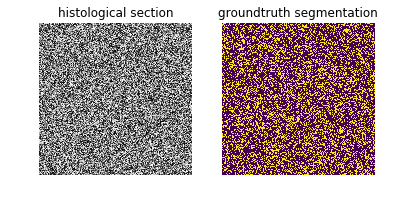

In [20]:
#load and display test section
X_test = np.random.randint(low=0, high=256, size=(2000,2000), dtype=np.uint)
Y_test = np.random.randint(low=0, high=3, size=(2000,2000), dtype=np.uint)

fig, axes = plt.subplots(1,2)
axes[0].imshow(X_test, cmap="gray")
axes[0].set_title("histological section")
axes[1].imshow(Y_test==1)
axes[1].set_title("groundtruth segmentation")
for ax in axes:
    ax.axis("off")

**Challenge**: Histological sections are too large to process at once during training:
- GPU memory too small,
- effective number of training samples too low

**Solution**: Crop small patches from input images and use for training

*Choices for patch sampling*:
- How large should the input be?
    - Trade-off between efficiency (shared computations for convolutions for large inputs) and variability of data (many small inputs show more different data than one large input)
    - Input patches need to show relevant context
    - Minimal input size may be limited by choice of network architecture (more on that later!)
    - Here, patch size of 255x255px is chosen. 255x255 px at 20um per px effectively shows 5x5mm of tissue. Sufficient for gray/white matter segmentation
- How many patches should be sampled?
    - As many as possible! Here, patches are computed beforehand (reproducible and faster), but random sampling during training is also possible and increases the variability of the training data
- Where should the patches be sampled from?
    - From the interesting parts of the image!
    - E.g., higher sampling rate from cortex and white matter than background might be beneficial
    - Here, patches were sampled randomly (possibly not the optimal strategy!)

Train dataset shape (n_samples, height, width, n_channels): (100, 255, 255, 1)
Val dataset shape (n_samples, height, width, n_channels): (10, 255, 255, 1)


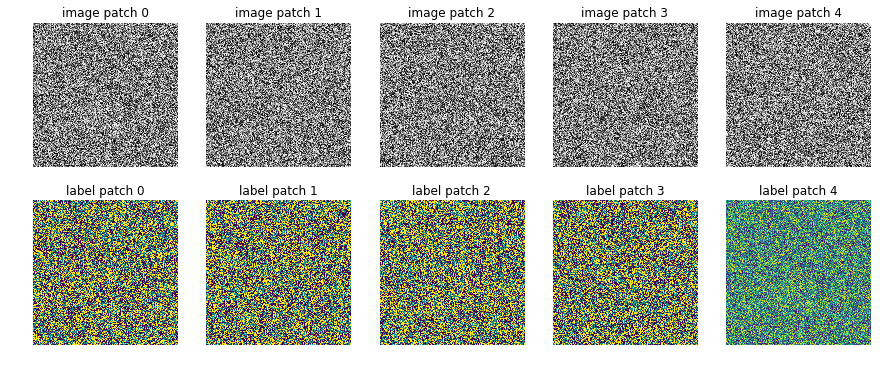

In [26]:
#TODO load precomputed train and test data

X_train = np.random.randint(low=0, high=256, size=(100,255,255,1), dtype=np.uint)
Y_train = np.random.randint(low=0, high=3, size=(100,255,255,1), dtype=np.uint)

X_val = np.random.randint(low=0, high=256, size=(10,255,255,1), dtype=np.uint)
Y_val = np.random.randint(low=0, high=3, size=(10,255,255,1), dtype=np.uint)

print("Train dataset shape (n_samples, height, width, n_channels): {}".format(X_train.shape))
print("Val dataset shape (n_samples, height, width, n_channels): {}".format(X_val.shape))

#TODO show a few images in nice grid with label and image caption 'example test patches'
fig, axes = plt.subplots(2,5, figsize=(15,6))
for i,ax in enumerate(axes[0]):
    ax.imshow(X_train[i,:,:,0], cmap='gray')
    ax.axis('off')
    ax.set_title('image patch {}'.format(i))
for i,ax in enumerate(axes[1]):
    ax.imshow(Y_train[i,:,:,0])
    ax.axis('off')
    ax.set_title('label patch {}'.format(i))
plt.imshow(X_train[0,:,:,0])

# 2. U-Net architecture for image segmentation
- Neural network for segmentation of large images should be memory-efficient, to enable training with large batch sizes
- U-Net is good choice for segmentation (Ronneberger, 2015)
    - Fully-convolutional, allows tiled prediction of very large images
    - Downsampling branch consisting of blocks of two convolutions and a pooling layer
    - Upsampling branch consisting of an upsampling layer and two convolutions

<img src="files/u-net-architecture.png" style="width:600px">

*Choices for design of custom U-Net*:
- How many blocks? How many convolutions per block? What filter size? Etc...
    - Original U-net architecture is a good starting point, but might not be optimal
    - *Receptive field* is important. This determines how many pixels the network "sees" for the prediction of one pixel. The receptive field is increased by pooling layers and convolutional layers
   
**Important**: If tiled segmentation of a large image is desired, only *valid* convolutions should be used 
- Otherwise, predictions at the borders of the image patches are not correct
- This results in a smaller output size than input size
- Groundtruth labels need to be cropped to the smaller output size when calculating performance metrics


In [4]:
def crop_to_shape_tensor(input_tensor, template_tensor):
    """Crop input_tensor to the shape of template_tensor by applying a cropping2D layer.
    Throw ValueError if template_tensor has a larger size than input_tensor
    
    Args:
        input_tensor: Tensor with shape attribute
        template_tensor: Tensor with shape attribute
    """
    from_shape = np.array(input_tensor.shape.as_list()[1:3])
    to_shape = np.array(template_tensor.shape.as_list()[1:3])
    if np.any(to_shape > from_shape):
        raise ValueError("template_tensor is larger than input_tensor with shapes {} and {}".format(to_shape, from_shape))
    # crop from left/top
    crop1 = np.floor((from_shape-to_shape)/2.).astype(int)
    # crop from right/bottom
    crop2 = np.ceil((from_shape-to_shape)/2.).astype(int)
    cropped_tensor = Cropping2D(cropping=((crop1[0], crop2[0]), (crop1[1], crop2[1])))(input_tensor)
    return cropped_tensor

def crop_to_shape(arr, shape):
    """Crop arr to the shape of template_arr.
    Throw ValueError if shape is larger than arr.shape
    
    Args:
        arr: np.array with shape (., h, w, .)
        shape: desired shape (h,w)
    """
    from_shape = np.array(arr.shape[1:3])
    to_shape = np.array(shape)
    if np.any(to_shape > from_shape):
        raise ValueError('shape is larger than arr.shape with {} {}'.format(to_shape, from_shape))
    crop = np.floor((from_shape-to_shape)/2.).astype(np.uint8)
    return arr[:,crop[0]:shape[0]+crop[0],crop[1]:shape[1]+crop[1]]
    

In [5]:
# U-Net definition
def u_net(input_tensor):
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(input_tensor)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
 
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='valid')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='valid')(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    # due to border pixel loss, conv3 is larger than up5 - crop conv3 to shape of up5 to concatenate
    crop3 = crop_to_shape_tensor(conv3, up5)
    conc5 = Concatenate(axis=3)([up5, crop3])
    conv5 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(conc5)
    conv5 = Convolution2D(128, (3, 3), activation='relu', padding='valid')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    crop2 = crop_to_shape_tensor(conv2, up6)
    conc6 = Concatenate(axis=3)([up6, crop2])
    conv6 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(conc6)
    conv6 = Convolution2D(64, (3, 3), activation='relu', padding='valid')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    crop1 = crop_to_shape_tensor(conv1, up7)
    conc7 = Concatenate(axis=3)([up7, crop1])
    conv7 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(conc7)
    conv7 = Convolution2D(32, (3, 3), activation='relu', padding='valid')(conv7)

    output_tensor = Convolution2D(3, (1, 1), activation='softmax')(conv7)

    return keras.models.Model(input=[input_tensor], output=output_tensor)
    
input_tensor = Input(shape=X_train.shape[1:])
model = u_net(input_tensor)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 255, 255, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 253, 253, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 251, 251, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 125, 125, 32) 0           conv2d_2[0][0]                   
_____________________________________

/home/hannah/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`


In [6]:
# receptive size of this model
# TODO get core from christian for this!

# 3. Neural network training 
*Training hyperparameters*:
- Optimizer: SGD with learning rate 0.001, momentum 0.9 (other choices are e.g. Adam optimizer)
- Number of iterations: 2 epochs with batch size 32
- Metric: crossentropy during training and accuracy during evaluation (other choices for segmentation are e.g.  Dice/F1 score)
- Input data is centered to mean 0 and stddev 1
- **Data augmentation**: currently none, more on that later!

In [7]:
# crop groundtruth labels to fit to the smaller output size of the model (due to only 'valid' convolutions)
Y_train_cropped = crop_to_shape(Y_train, model.output.shape.as_list()[1:3])
Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])
print("Shape before cropping: {}. Shape after cropping: {}.".format(Y_train.shape, Y_train_cropped.shape))

# create generator for batches that centers mean and std deviation of training data
datagen = ImageDataGenerator(featurewise_center=True)
datagen.fit(X_train)

Shape before cropping: (100, 255, 255, 1). Shape after cropping: (100, 164, 164, 1).


In [25]:
# parameters for training
lr = 0.001
momentum = 0.9
epochs = 4
batch_size = 1
model_name = 'my_model.hdf5'

# prepare model for training
sgd = SGD(lr=lr, momentum=momentum, nesterov=True)

# use accuracy function from current Keras master, function in keras-2 release does not work as expected for segmentation
def sparse_categorical_accuracy(y_true, y_pred):
    import keras.backend as K
    # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
    if K.ndim(y_true) == K.ndim(y_pred):
        y_true = K.squeeze(y_true, -1)
    # convert dense predictions to labels
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_pred_labels = K.cast(y_pred_labels, K.floatx())
    return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=[sparse_categorical_accuracy] )

# train model
history = model.fit_generator(datagen.flow(X_train, Y_train_cropped, batch_size=batch_size),
                             steps_per_epoch=1, #X_train.shape[0]//batch_size, 
                              epochs=epochs, verbose=2,
                             validation_data=(X_val, Y_val_cropped))

# save model   
model.save(model_name)



Epoch 1/4
 - 6s - loss: 1.7249 - sparse_categorical_accuracy: 0.3315 - val_loss: 2.8595 - val_sparse_categorical_accuracy: 0.3332
Epoch 2/4
 - 5s - loss: 1.6488 - sparse_categorical_accuracy: 0.3346 - val_loss: 2.3991 - val_sparse_categorical_accuracy: 0.3328
Epoch 3/4
 - 4s - loss: 1.5532 - sparse_categorical_accuracy: 0.3333 - val_loss: 2.2833 - val_sparse_categorical_accuracy: 0.3331
Epoch 4/4
 - 6s - loss: 1.4498 - sparse_categorical_accuracy: 0.3366 - val_loss: 2.0343 - val_sparse_categorical_accuracy: 0.3327


Plot prograss of train and val loss

In [26]:
print(history.history.keys())

['sparse_categorical_accuracy', 'loss', 'val_sparse_categorical_accuracy', 'val_loss']


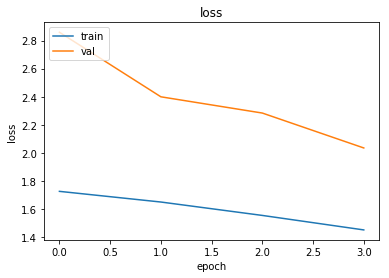

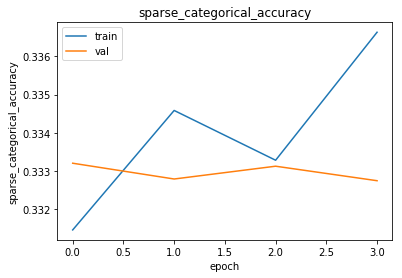

In [27]:
def plot_history(history, key='loss'):
    # summarize history for accuracy
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title(key)
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
plot_history(history, key='loss')
plot_history(history, key='sparse_categorical_accuracy')

# Evaluate model
- evaluate on whole slide histological images
    - if fits in memory, can predict at once, otherwise need to do patch-wise prediction
    - need to create model with correct input size input sizes to evaluate large images and load save weights

In [9]:
X_val.shape

(10, 255, 255, 1)

In [16]:
xx, yy = np.meshgrid(range(0,255,10), range(0,255,10))
np.array((xx.ravel(), yy.ravel())).T.shape

(676, 2)

In [ ]:
# predict large image by predicting grid of small overlapping images

# functions for creating overlapping patches
def create_grid(img, spacing):
    """Calculate evenly spaced grid over image
    Args:
        img: array with shape (h,w)
        spacing: int
    Returns:
        list of tuples denoting the coordinate of each grid point
    """
    xx, yy = np.meshgrid(range(0, img.shape[0], spacing), range(0, img.shape[1], spacing))
    return np.array((xx.ravel(), yy.ravel())).T
    
def sample_from_coords(img, coords, patch_shape, pad=0):
    """Sample patches from coords
    Args:
        img: array with shape (h,w)
        coords: list of tuples denoting the center coordinate of each patch
        patch_shape: size of patches that should be sampled
        pad: int, padding value that is added if patches exceed image size
    """
    

In [38]:
# add dims to X_test and Y_test (single image) to get correct input shape
X_test_expanded = np.expand_dims(np.expand_dims(X_test, axis=0), axis=3)
Y_test_expanded = np.expand_dims(np.expand_dims(Y_test, axis=0), axis=3)


In [39]:
# recreate unet model with larger input size
input_tensor = Input(shape=X_test_expanded.shape[1:])
eval_model = u_net(input_tensor)
eval_model.load_weights(model_name)

/home/hannah/pyenv/lib/python2.7/site-packages/ipykernel_launcher.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`


In [ ]:
Y_pred = eval_model.predict(X_test_expanded)

In [ ]:
    eval_model.

In [ ]:

Y_val_cropped = crop_to_shape(Y_val, model.output.shape.as_list()[1:3])

In [35]:
model.predict(np.expand_dims(np.expand_dims(X_test, axis=0), axis=3))

ValueError: Error when checking input: expected input_1 to have shape (255, 255, 1) but got array with shape (2000, 2000, 1)

In [ ]:
#test_score = model.evaluate(X_test_pet, Y_test_pet)
#print("Test :", test_score)

In [24]:
model.evaluate?

In [19]:
tf.__version__

'1.13.1'

# Improve performance with data augmentation

In [18]:
import tensorflow as tf

# Other ideas for improving performance

In [17]:
keras.__version__

'2.2.4'

# What did the model learn? Saliency analysis